In [ ]:
!pip install timm
!pip install torchvision
!pip install wandb
import zipfile
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from tqdm import tqdm
import wandb
!unzip /content/cats-faces.zip

Archive:  /content/cats-faces.zip
replace cats/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

import torch.nn.functional as F

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_SAMPLES = 12
RUN_NAME = 'baseline_gan'
SEED = 0
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
BETA1 = 0.5
BETA2 = 0.999
LATENT_DIMS = 100
NUM_GEN_KERN = 128
NUM_DISC_KERN = 128
NUM_CHANNELS = 3
EPOCHS = 20

In [ ]:
def prepare_data(BATCH_SIZE):

    num_cores = os.cpu_count()

    transformation = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    train_set = torchvision.datasets.ImageFolder(
        '/content/cats',
        transform=transformation
    )

    dataset_size = len(train_set)
    trimmed_dataset_size = dataset_size - (dataset_size % BATCH_SIZE)
    train_set.samples = train_set.samples[:trimmed_dataset_size]
    train_set.targets = train_set.targets[:trimmed_dataset_size]

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_cores
        )

    return train_loader


def initialize_weights(mod):
    classname = mod.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(mod.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(mod.weight.data, 1.0, 0.02)
        nn.init.constant_(mod.bias.data, 0)


def reset_gradients(network):
    for param in network.parameters():
        param.grad = None


def model_setup(device=DEVICE):
    generator = Generator()
    generator.apply(initialize_weights)
    generator.to(device)

    discriminator = Discriminator()
    discriminator.apply(initialize_weights)
    discriminator.to(device)

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

    return generator, discriminator, gen_optimizer, disc_optimizer

def train_setup(images, discriminator):

    actual_images = images.to(DEVICE)
    real_batch_size = discriminator(actual_images).view(-1).size(0)
    real_label = torch.ones((real_batch_size, ), dtype=torch.float32, device=DEVICE)
    fake_label = torch.zeros((real_batch_size, ), dtype=torch.float32, device=DEVICE)

    return actual_images, real_batch_size, real_label, fake_label

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.network = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=LATENT_DIMS,
            out_channels=NUM_GEN_KERN * 8,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 8,
            out_channels=NUM_GEN_KERN * 4  ,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 4,
            out_channels=NUM_GEN_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 2,
            out_channels=NUM_GEN_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.Tanh(),
    )

  def forward(self, input):
    return self.network(input)


class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.network = nn.Sequential(
        nn.Conv2d(
            in_channels=NUM_CHANNELS,
            out_channels=NUM_DISC_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN,
            out_channels=NUM_DISC_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 2,
            out_channels=NUM_DISC_KERN * 4,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 4,
            out_channels=NUM_DISC_KERN * 8,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 8,
            out_channels=1,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
            ),
        nn.Sigmoid()
        )

  def forward(self, input):
    return self.network(input)

In [ ]:
def run():

    wandb.init(
        project='CAT-GAN',
        config={
        'num_samples': NUM_SAMPLES,
        'run_name': RUN_NAME,
        'seed': SEED,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'beta1': BETA1,
        'beta2': BETA2,
        'latent_dims': LATENT_DIMS,
        'num_gen_kern': NUM_GEN_KERN,
        'num_disc_kern': NUM_DISC_KERN,
        'num_channels': NUM_CHANNELS,
        'epochs': EPOCHS
    })

    config = wandb.config

    if not os.path.exists('/content/logs'):
      os.mkdir('/content/logs')
    if not os.path.exists(f'/content/logs/{config.run_name}'):
      os.mkdir(f'/content/logs/{config.run_name}')

    manual_seed = config.seed
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)

    if torch.cuda.is_available():
      torch.cuda.manual_seed(manual_seed)
      torch.cuda.manual_seed_all(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    train_loader = prepare_data(config.batch_size)

    generator, discriminator, gen_optimizer, disc_optimizer = model_setup()

    gen_losses = []
    disc_losses = []
    real_confs = []
    fake_confs = []
    generated_confs = []

    discriminator.train()
    generator.train()

    for epoch in range(1, config.epochs + 1):

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            actual_images, real_batch_size, real_label, fake_label = train_setup(images, discriminator)

            # 1: train discrim
            reset_gradients(discriminator)

            out = discriminator(actual_images).view(-1)
            real_loss = F.binary_cross_entropy(out, real_label)
            real_conf = real_loss.mean().item()


            # 2: full pass on generated images
            noise = torch.randn(config.batch_size, config.latent_dims, 1, 1, device=DEVICE)

            fake_images = generator(noise)
            out = discriminator(fake_images.detach()).view(-1)
            fake_loss = F.binary_cross_entropy(out, fake_label)
            fake_conf = fake_loss.mean().item()
            discriminator_loss = real_loss + fake_loss
            discriminator_loss.backward()
            disc_optimizer.step()

            # 3: train generator
            reset_gradients(generator)

            out = discriminator(fake_images).view(-1)
            generator_loss = F.binary_cross_entropy(out, real_label)
            generator_loss.backward()
            generated_conf = generator_loss.mean().item()

            gen_optimizer.step()

            s_metrics = {
                'discriminator_loss': discriminator_loss.item(),
                'generator_loss': generator_loss.item(),
                'real_conf': real_conf,
                'fake_conf': fake_conf,
                'generated_conf': generated_conf
            }

            gen_losses.append(generator_loss.item())
            disc_losses.append(discriminator_loss.item())
            real_confs.append(real_conf)
            fake_confs.append(fake_conf)
            generated_confs.append(generated_conf)

        discriminator_loss = sum(disc_losses) / len(disc_losses)
        generator_loss = sum(gen_losses) / len(gen_losses)
        real_conf = sum(real_confs) / len(real_confs)
        fake_conf = sum(fake_confs) / len(fake_confs)
        generated_conf = sum(generated_confs) / len(generated_confs)

        e_metrics = {
            'discriminator_loss': discriminator_loss,
            'generator_loss': generator_loss,
            'real_conf': real_conf,
            'fake_conf': fake_conf,
            'generated_conf': generated_conf,
        }
        wandb.log({**s_metrics, **e_metrics})
        print(f'Epoch ', epoch, '/', config.epochs, ': Discriminator Loss: ', sum(disc_losses) / len(disc_losses), 'Generator: ', sum(gen_losses) / len(gen_losses))

        samples = []
        static_noise = torch.randn(real_batch_size, config.latent_dims, 1, 1, device=DEVICE)
        generator.eval()
        samples = generator(static_noise)

        grid = vutils.make_grid(samples[:25], normalize=True, nrow=5, scale_each=True)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        grid = (grid * 255).astype(np.uint8)
        wandb.log({'samples': wandb.Image(grid)})

        if epoch % 5 == 0 or epoch == 1:
            plt.figure(figsize=(10, 10))
            for x in range(25):
                sample = samples[x]
                sample = sample.cpu().detach().numpy()
                sample = sample.transpose(1, 2, 0)
                sample = (sample + 1) / 2
                plt.subplot(5, 5, x + 1)
                plt.imshow(sample)
                plt.axis('off')
            plt.show()
        generator.train()

        torch.save(generator.state_dict(), f'/content/logs/{config.run_name}/generator_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/logs/{config.run_name}/discriminator_{epoch}.pth')

        torch.cuda.empty_cache()
    wandb.finish()
    return generator, discriminator

  0%|          | 0/492 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/AT

Epoch  1 / 20 : Discriminator Loss:  0.11073942593420553 Generator:  62.20428897501007


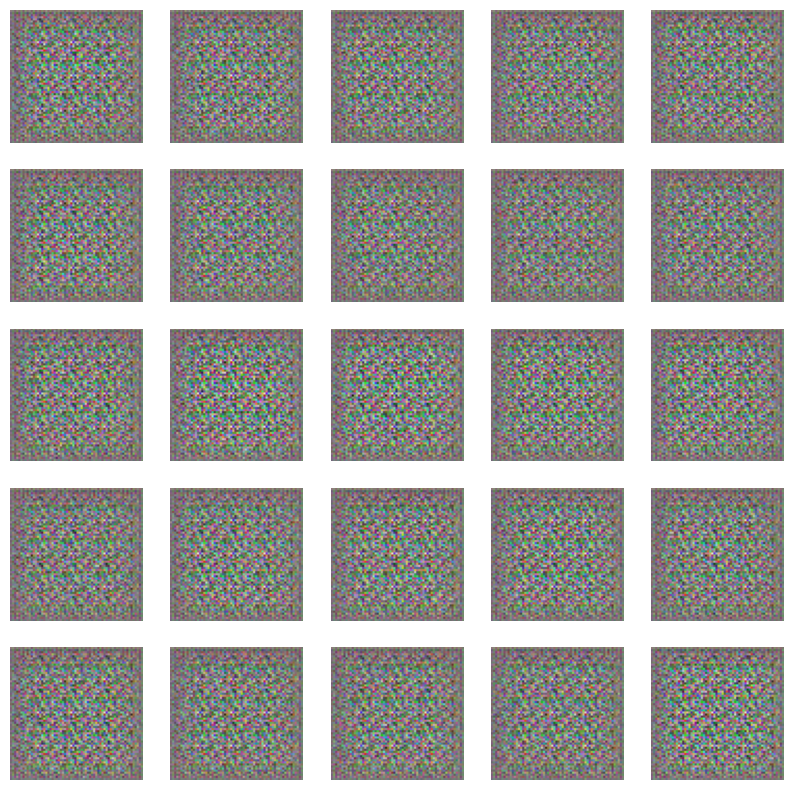

100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  2 / 20 : Discriminator Loss:  0.05537003688236772 Generator:  61.92004248184887


100%|██████████| 492/492 [01:54<00:00,  4.28it/s]


Epoch  3 / 20 : Discriminator Loss:  0.036913513708240565 Generator:  61.80327078578918


100%|██████████| 492/492 [01:54<00:00,  4.28it/s]


Epoch  4 / 20 : Discriminator Loss:  0.027685203476754558 Generator:  61.7314413398262


100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  5 / 20 : Discriminator Loss:  0.022148203772093547 Generator:  61.68686170733072


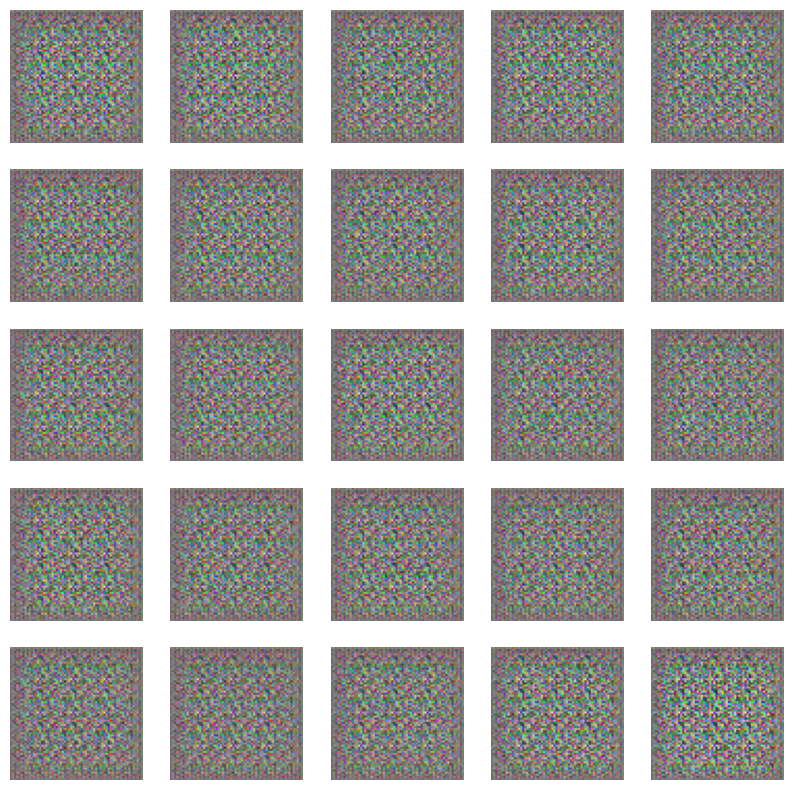

100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  6 / 20 : Discriminator Loss:  0.018456858094423267 Generator:  61.647453039965335


100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  7 / 20 : Discriminator Loss:  0.01582017823163988 Generator:  61.611944604556875


100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  8 / 20 : Discriminator Loss:  0.013842664873214934 Generator:  61.585936182398136


100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  9 / 20 : Discriminator Loss:  0.01230459707013084 Generator:  61.56216874204462


100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  10 / 20 : Discriminator Loss:  0.011074141527587587 Generator:  61.54639600544441


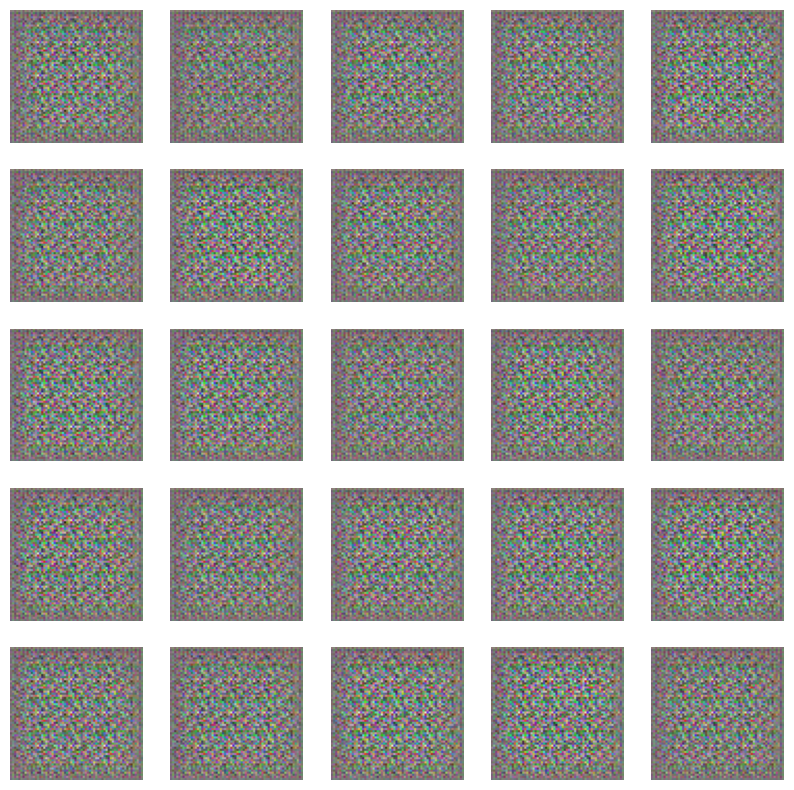

100%|██████████| 492/492 [01:54<00:00,  4.29it/s]


Epoch  11 / 20 : Discriminator Loss:  0.01006740461978979 Generator:  61.529444926770104


100%|██████████| 492/492 [01:54<00:00,  4.31it/s]


Epoch  12 / 20 : Discriminator Loss:  0.00922845659214649 Generator:  61.498151302014584


100%|██████████| 492/492 [01:54<00:00,  4.30it/s]


Epoch  13 / 20 : Discriminator Loss:  0.008518576972292915 Generator:  61.46465728877857


100%|██████████| 492/492 [01:54<00:00,  4.30it/s]


Epoch  14 / 20 : Discriminator Loss:  0.007910108344870602 Generator:  61.4296293383276


100%|██████████| 492/492 [01:54<00:00,  4.31it/s]


Epoch  15 / 20 : Discriminator Loss:  0.00738276874712806 Generator:  61.39796240452505


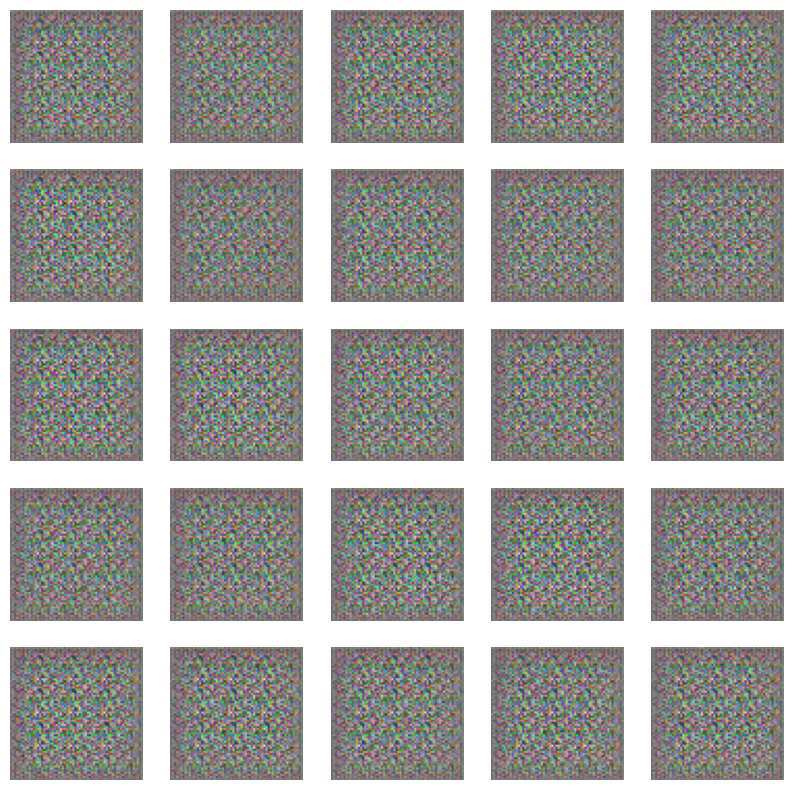

100%|██████████| 492/492 [01:54<00:00,  4.31it/s]


Epoch  16 / 20 : Discriminator Loss:  0.006921346368165 Generator:  61.362757164530635


100%|██████████| 492/492 [01:53<00:00,  4.32it/s]


Epoch  17 / 20 : Discriminator Loss:  0.0065142089437848424 Generator:  61.31756092497517


100%|██████████| 492/492 [01:54<00:00,  4.31it/s]


Epoch  18 / 20 : Discriminator Loss:  0.006152308793104492 Generator:  61.26904482203986


100%|██████████| 492/492 [01:54<00:00,  4.31it/s]


Epoch  19 / 20 : Discriminator Loss:  0.005828503311838131 Generator:  61.20240319973901


100%|██████████| 492/492 [01:54<00:00,  4.28it/s]


Epoch  20 / 20 : Discriminator Loss:  0.2311237847286425 Generator:  58.716779643684866


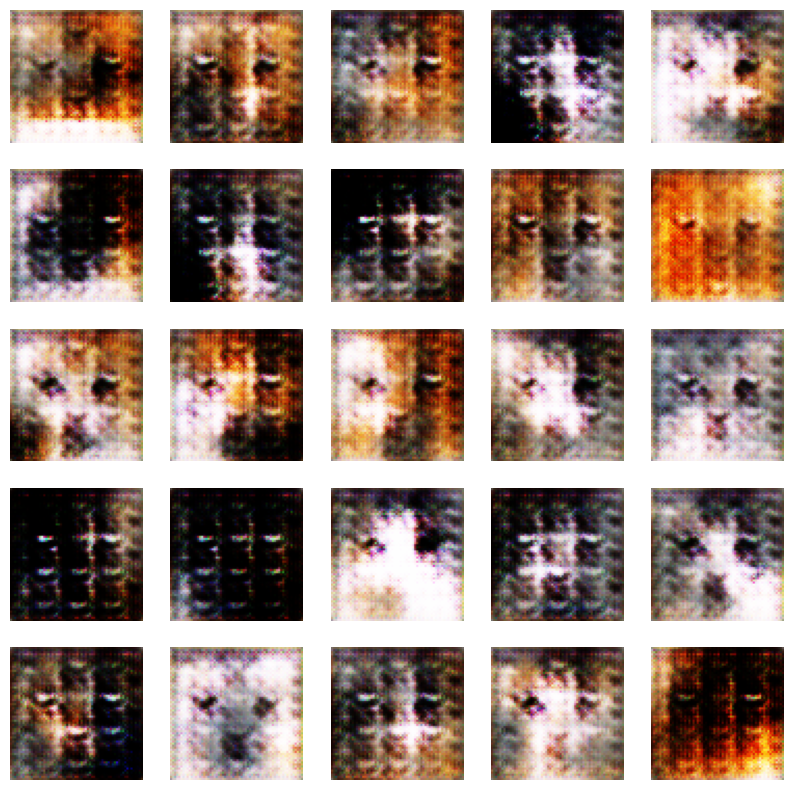

In [ ]:
gen, disc = run()